In [1]:
import os
import glob
import h5py
import matplotlib.pyplot as plt
import lightgbm as lgb  
import numpy as np  
import pandas as pd  
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Summary
1. Cleaning and exploring data 
2. Feature engineering
3. HFT strategy based on momentum
4. Tree-based LightGBM strategy for stock price prediction

### 1. Loading, cleaning and exploring the data of 002521 and 300132 for 4 months

- Droping the columns that consist of zeros, NaNs, and IDs, as these are not involved in subsequent calculations.
- Changing the storage format of all data to reduce memory consumption.
- Converting the DataTime column to a time series and arranging all data sequentially based on it.
- Ploting the daily variations of returns, volume, volatility, turnover.

### 1.1 Loading Data

In [2]:

data_dir = r"interview"
files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".h5")]

df_list = []
for fn in files:
    try:
        with h5py.File(fn, "r") as hf:
            data = {k: hf[k][:] for k in hf.keys() if isinstance(hf[k], h5py.Dataset)}
            df_list.append(pd.DataFrame(data))
            (f"Loaded {fn} → {len(df_list[-1])} rows")
    except Exception as e:
        (f"Skipped {fn}: {e}")

df = pd.concat(df_list, ignore_index=True)
print(f"Total records: {len(df)}")

Total records: 2786595


In [3]:
df.head()

,AskPrice1,AskPrice10,AskPrice2,AskPrice3,AskPrice4,AskPrice5,AskPrice6,AskPrice7,AskPrice8,AskPrice9,...,Nano,OpenPrice,PreClosePrice,PreSettlPrice,SettlPrice,TradesCount,TradingDay,Turnover,UpperLimitPrice,Volume
0,5.16,5.25,5.17,5.18,5.19,5.2,5.21,5.22,5.23,5.24,...,1654047000353327615,0.0,0.0,0.0,0.0,0,20220601,0.0,0.0,0
1,5.16,5.25,5.17,5.18,5.19,5.2,5.21,5.22,5.23,5.24,...,1654047000747287878,0.0,0.0,0.0,0.0,0,20220601,0.0,0.0,0
2,5.16,5.25,5.17,5.18,5.19,5.2,5.21,5.22,5.23,5.24,...,1654047000990003034,0.0,0.0,0.0,0.0,0,20220601,0.0,0.0,0
3,5.16,5.25,5.17,5.18,5.19,5.2,5.21,5.22,5.23,5.24,...,1654047001034141844,0.0,0.0,0.0,0.0,0,20220601,0.0,0.0,0
4,5.16,5.25,5.17,5.18,5.19,5.2,5.21,5.22,5.23,5.24,...,1654047001102109385,0.0,0.0,0.0,0.0,0,20220601,0.0,0.0,0


In [5]:
df["DataTime"] = df["DataTime"].astype(str).str.zfill(17)
df["时间"] = pd.to_datetime(df["DataTime"], format="%Y%m%d%H%M%S%f", errors="coerce")
df.drop(columns=["DataTime"], inplace=True)
df.sort_values("时间", inplace=True)

mask = df["时间"].dt.time.between(pd.to_datetime("09:30").time(), pd.to_datetime("11:30").time()) | \
       df["时间"].dt.time.between(pd.to_datetime("13:00").time(), pd.to_datetime("15:00").time())
df = df[mask]

In [6]:
df["mid_price"] = (df["BidPrice1"] + df["AskPrice1"]) / 2
df["date"] = df["时间"].dt.date
df["minute"] = df["时间"].dt.floor("min") 

df = df[df["InstrumentID"].isin([2521, 300132])]

### 1.2 Cleaning and sorting the data
- Droping the columns that consist entirely of zeros, NaNs, and IDs, as these are not involved in subsequent calculations.
- Changing the storage format of all data to reduce memory consumption.
- Converting the DataTime column to a time series and arrange all data sequentially based on it.

In [7]:
def combine_h5_files(folder_path, file_pattern='*.h5'):

    # Generate the file-matching pattern
    pattern = os.path.join(folder_path, file_pattern)

    df_list = []

    # Iterate over each matching file
    for file_path in glob.glob(pattern):
        with h5py.File(file_path, 'r') as f:
            columns = list(f.keys())
            data_dict = {}

            # Build a dictionary { column_name: numpy_array_of_values }
            for col in columns:
                data_dict[col] = f[col][:]

            # Convert this file's data into a DataFrame
            df_temp = pd.DataFrame(data_dict)

        df_list.append(df_temp)

    # Concatenate all DataFrames into one
    if df_list:
        df_combined = pd.concat(df_list, ignore_index=True)
    else:
        # In case no files match, return an empty DataFrame
        df_combined = pd.DataFrame()

    return df_combined

In [8]:
def clean_dataframe(df):

    columns_all_zero = [col for col in df.columns if (df[col] == 0).all()]

    df.drop(columns=columns_all_zero, inplace=True)

    if 'Nano' in df.columns:
        df.drop(columns=['Nano'], inplace=True)
    if 'TradingDay' in df.columns:
        df.drop(columns=['TradingDay'], inplace=True)
    if 'InstrumentID' in df.columns:
        df.drop(columns=['InstrumentID'], inplace=True)

    return df

def sort_by_datatime(df):

    if not pd.api.types.is_datetime64_any_dtype(df['DataTime']):
        try:

            df['DataTime'] = pd.to_datetime(df['DataTime'], format='%Y%m%d%H%M%S%f')
        except ValueError:

            pass

    df.sort_values(by='DataTime', inplace=True)

    df.reset_index(drop=True, inplace=True)

    return df

def reduce_column_size(df):

    df_reduced = df.copy()

    int_cols = df_reduced.select_dtypes(include=['int64']).columns
    for col in int_cols:
        df_reduced[col] = pd.to_numeric(df_reduced[col], downcast='integer')

    float_cols = df_reduced.select_dtypes(include=['float64']).columns
    for col in float_cols:
        df_reduced[col] = pd.to_numeric(df_reduced[col], downcast='float')

    return df_reduced

In [9]:
df_002521 = combine_h5_files('interview', '002521*.h5') # load
df_300132 = combine_h5_files('interview', '300132*.h5')
df_002521 = clean_dataframe(df_002521) # clean
df_300132 = clean_dataframe(df_300132)
df_002521 = sort_by_datatime(df_002521) # timestamp
df_300132 = sort_by_datatime(df_300132)
df_002521 = reduce_column_size(df_002521) # reduce RAM
df_300132 = reduce_column_size(df_300132)

### 1.3 Exploratory Data Analysis: the daily variations of returns, volume, volatility, & turnover

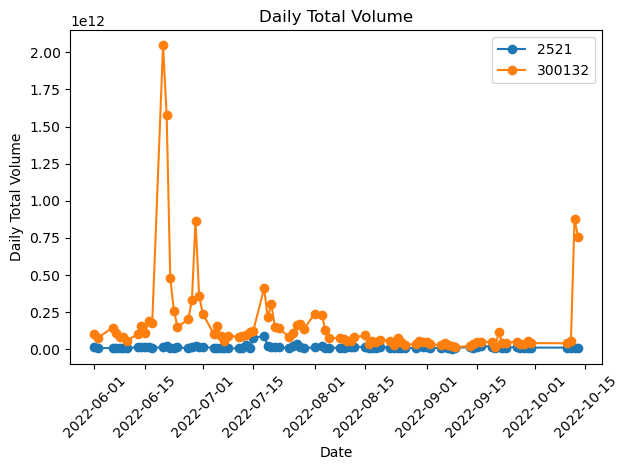

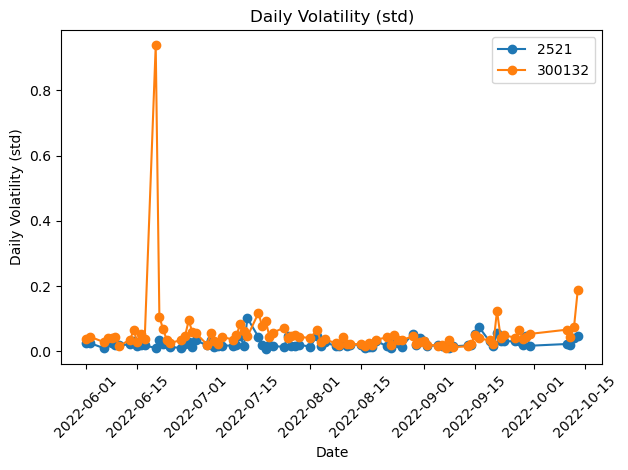

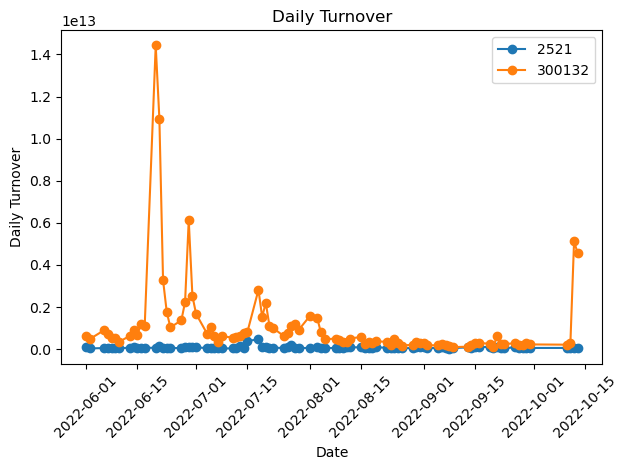

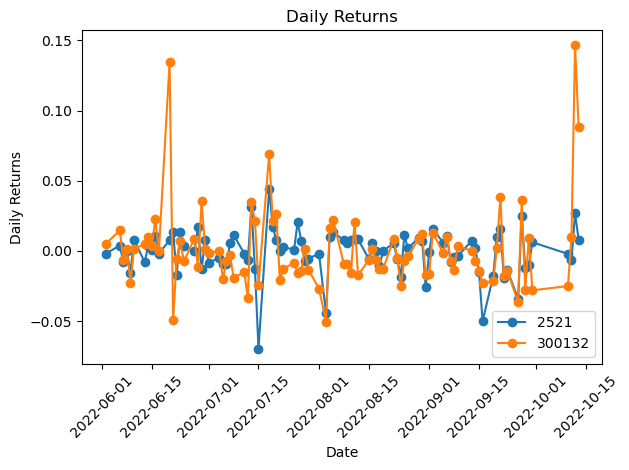

In [10]:
daily = df.groupby(["InstrumentID","date"]).agg(
    total_volume=("Volume","sum"),
    volatility=("mid_price","std"),
    turnover=("Turnover","sum"),
    close_price=("mid_price","last")  # capture the last mid_price of the day
).reset_index()
daily["returns"] = daily.groupby("InstrumentID")["close_price"].pct_change()
metrics = {
    "total_volume": "Daily Total Volume",
    "volatility": "Daily Volatility (std)",
    "turnover": "Daily Turnover",
    "returns": "Daily Returns"
}

for metric, title in metrics.items():
    plt.figure()
    for inst in daily["InstrumentID"].unique():
        inst_daily = daily[daily["InstrumentID"] == inst]
        plt.plot(inst_daily["date"], inst_daily[metric], marker="o", label=f"{inst}")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(title)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
# daily["returns"] = 100 * daily.groupby("InstrumentID")["close_price"].pct_change()

### 2. Feature engineering

These features were developed to reflect the imbalance, liquidity, price dynamics, and statistics of volume and prices
- imbalance = bid_volume1-10/(bid_volume1-10 + ask_volume1-10)
- delta_imbalance = imbalance - (last imbalance)
- rolling_delta_imb = (sum of delta_imbalance in past 5 rows)/5
- returns = price.pct_change()
- volatilities in different period 10s, 1min, 1Hour, 1D, 7D, 30D
- midprice = (BidPrice1 + AskPrice1)/2
- spread = (AskPrice1 - BidPrice1)
- momentum = turnover * return
- size_imbalance" = total_bid_volume / total_bid_volume
- spread_intensity = spread.diff()
- 'market_urgency' = 'spread * liquidity_imbalance
- order_book_imbalance = (total_ask_volume - total_bid_volume)/(total_ask_volume + total_bid_volume + 1e-6)
- weighted_bid_price based on the bid_volume1-10
- weighted_ask_price based on the ask_volume1-10
- bid_price_gap = weighted_bid_price - BidPrice1
- ask_price_gap = weighted_ask_price = AskPrice1
- mean, std, medium of bidprice
- mean, std, medium of askprice
- top3 ask volume sum
- top3 bid volume sum

In [11]:
# calculate order book imbalance metrics from Level 2 market data:

def generate_level2_imbalance(df, bid_levels=10, ask_levels=10, time_col='DataTime'):

    df = df.sort_values(by=time_col).copy() 
    
    ask_volume_cols = [f"AskVolume{i}" for i in range(1, ask_levels + 1) if f"AskVolume{i}" in df.columns]
    bid_volume_cols = [f"BidVolume{i}" for i in range(1, bid_levels + 1) if f"BidVolume{i}" in df.columns]
 
    df["total_bid_volume"] = df[bid_volume_cols].sum(axis=1)
    df["total_ask_volume"] = df[ask_volume_cols].sum(axis=1)
    df["total_volume"] = df["total_bid_volume"] + df["total_ask_volume"]
    
    df["imbalance"] = df["total_bid_volume"] / (df["total_bid_volume"] + df["total_ask_volume"])
    df["imbalance"] = df["imbalance"].fillna(0.5)
    df["delta_imbalance"] = df["imbalance"].diff()
    df['rolling_delta_imb'] = df['delta_imbalance'].rolling(window=5).mean()
    
    return df

In [12]:
# calculate rolling volatility
def add_rolling_volatility(
    df,
    time_col='DataTime',
    price_col='LastPrice',
    window='1D',
    new_col='volatility',
    use_log_returns=False
):

    df_local = df.copy()   # A local copy of df is made to avoid modifying the original input data.

    if not pd.api.types.is_datetime64_any_dtype(df_local[time_col]):
        df_local[time_col] = pd.to_datetime(df_local[time_col], errors='coerce')

    df_local.sort_values(by=time_col, inplace=True)

    # Calculate returns. Two options:
    if use_log_returns:
        df_local['returns'] = np.log(df_local[price_col].pct_change() + 1)
    else:
        df_local['returns'] = df_local[price_col].pct_change()

    df_local.dropna(subset=['returns'], inplace=True)    
    
    df_local[new_col] = (
        df_local
        .rolling(window=window, on=time_col)['returns']
        .std()
    )

    return df_local     

In [13]:
# apply the generate_level2_imbalance function (which we analyzed earlier) to two stocks' df
df_002521_signals = generate_level2_imbalance(df_002521, bid_levels=10, ask_levels=10, time_col='DataTime') #imbalance features
df_300132_signals = generate_level2_imbalance(df_300132, bid_levels=10, ask_levels=10, time_col='DataTime')

In [14]:
# create multiple volatility features
df_002521_signals = add_rolling_volatility(df_002521_signals, window='1D', new_col='daily_vol') # volatility features
df_002521_signals = add_rolling_volatility(df_002521_signals, window='7D', new_col='weekly_vol')
df_002521_signals = add_rolling_volatility(df_002521_signals, window='30D', new_col='monthly_vol')
df_002521_signals = add_rolling_volatility(df_002521_signals, window='1h', new_col='hourly_vol')
df_002521_signals = add_rolling_volatility(df_002521_signals, window='1min', new_col='min_vol')
df_002521_signals = add_rolling_volatility(df_002521_signals, window='1s', new_col='sec_vol')
df_002521_signals = add_rolling_volatility(df_002521_signals, window='10s', new_col='tenth_sec_vol')
df_300132_signals = add_rolling_volatility(df_300132_signals, window='1D', new_col='daily_vol')
df_300132_signals = add_rolling_volatility(df_300132_signals, window='7D', new_col='weekly_vol')
df_300132_signals = add_rolling_volatility(df_300132_signals, window='30D', new_col='monthly_vol')
df_300132_signals = add_rolling_volatility(df_300132_signals, window='1h', new_col='hourly_vol')
df_300132_signals = add_rolling_volatility(df_300132_signals, window='1min', new_col='min_vol')
df_002521_signals = add_rolling_volatility(df_002521_signals, window='1s', new_col='sec_vol')
df_002521_signals = add_rolling_volatility(df_002521_signals, window='10s', new_col='tenth_sec_vol')

In [15]:
# add new features: momentum, midprice, spread

df_002521_signals = df_002521_signals[df_002521_signals['LastPrice'] != 0]
df_300132_signals = df_300132_signals[df_300132_signals['LastPrice'] != 0]
df_002521_signals.set_index('DataTime', inplace=True)  
df_300132_signals.set_index('DataTime', inplace=True)

df_002521_signals ['momentum'] = df_002521_signals['Turnover']*df_002521_signals['returns'] 
df_002521_signals ['midprice'] = (df_002521_signals['AskPrice1'] + df_002521_signals['BidPrice1'])/2
df_002521_signals ['spread'] = df_002521_signals['AskPrice1'] - df_002521_signals['BidPrice1']

df_300132_signals ['momentum'] = df_300132_signals['Turnover']*df_300132_signals['returns']
df_300132_signals ['midprice'] = (df_300132_signals['AskPrice1'] + df_300132_signals['BidPrice1'])/2
df_300132_signals ['spread'] = df_300132_signals['AskPrice1'] - df_300132_signals['BidPrice1']

In [16]:
# Feature Engineering:

#1. Add high-level features related to order book imbalance and spread dynamics:
for df in [df_002521_signals, df_300132_signals]: 
    df["liquidity_imbalance"] = df.eval("(total_bid_volume - total_ask_volume)/(total_bid_volume + total_ask_volume)")
    df["size_imbalance"] = df.eval("total_bid_volume / total_ask_volume")
    df['spread_intensity'] = df['spread'].diff()  
    df['market_urgency'] = df['spread'] * df['liquidity_imbalance'] 
    df['order_book_imbalance'] = ((df['total_ask_volume']-df['total_bid_volume']) / 
                                  (df['total_ask_volume']+df['total_bid_volume']+ 1e-6))

#2. Defining Order Book bid, ask_volume and price Levels: 1~10
bid_volume_cols = [f'BidVolume{i}' for i in range(1, 11)]
ask_volume_cols = [f'AskVolume{i}' for i in range(1, 11)]
bid_price_cols = [f'BidPrice{i}' for i in range(1, 11)]
ask_price_cols = [f'AskPrice{i}' for i in range(1, 11)]

#3. Order Book Features
for df_features in [df_002521_signals, df_300132_signals]:
    # Volume-weighted average prices (VWAP) for bids/asks:
    df_features['weighted_bid_price'] = (df_features[bid_price_cols].mul(df_features[bid_volume_cols]).sum(axis=1) /
                                        (df_features['total_bid_volume'] + 1e-6))
    df_features['weighted_ask_price'] = (df_features[ask_price_cols].mul(df_features[ask_volume_cols]).sum(axis=1) /
                                        (df_features['total_ask_volume'] + 1e-6))
    # Gaps between weighted prices and best prices
    df_features['bid_price_gap'] = df_features['weighted_bid_price'] - df_features['BidPrice1']
    df_features['ask_price_gap'] = df_features['weighted_ask_price'] - df_features['AskPrice1']

    # Price differences between consecutive levels
    for i in range(1, 10):
        df_features[f'bid_price_diff_{i}_{i+1}'] = df_features[f'BidPrice{i}'] - df_features[f'BidPrice{i+1}']
        df_features[f'ask_price_diff_{i}_{i+1}'] = df_features[f'AskPrice{i+1}'] - df_features[f'AskPrice{i}']
   
    # Central tendency and variability of prices across levels
    df_features['avg_bid_price'] = df_features[bid_price_cols].mean(axis=1)
    df_features['avg_ask_price'] = df_features[ask_price_cols].mean(axis=1)
    df_features['median_bid_price'] = df_features[bid_price_cols].median(axis=1)
    df_features['median_ask_price'] = df_features[ask_price_cols].median(axis=1)
    df_features['std_bid_price'] = df_features[bid_price_cols].std(axis=1)
    df_features['std_ask_price'] = df_features[ask_price_cols].std(axis=1)
    df_features['best_volume_ratio'] = df_features['BidVolume1'] / (df_features['AskVolume1'] + 1e-6)
    df_features['volume_ratio'] = df_features['total_bid_volume'] / (df_features['total_ask_volume'] + 1e-6)

    # Volume ratios (imbalances)
    top3_bid_cols = [f'BidVolume{i}' for i in range(1, 4)]
    top3_ask_cols = [f'AskVolume{i}' for i in range(1, 4)]
    
    # Top 3 levels volume metrics
    df_features['top3_bid_volume'] = df_features[top3_bid_cols].sum(axis=1)
    df_features['top3_ask_volume'] = df_features[top3_ask_cols].sum(axis=1)
    df_features['top3_volume_ratio'] = df_features['top3_bid_volume'] / (df_features['top3_ask_volume'] + 1e-6)

    # Spread at each level
    for i in range(1, 11):
        df_features[f'spread_level_{i}'] = df_features[f'AskPrice{i}'] - df_features[f'BidPrice{i}']

This process transforms raw order book data into actionable features that describe:
- Imbalances between buyers and sellers (liquidity, volume ratios).
- Price structure across different depth levels (gaps, differences, averages).
- Spread dynamics (intensity, level-specific spreads).

These features are essential for modeling market behavior, predicting short-term price movements, or designing trading strategies that rely on order book insights.

### 3. HFT strategy based on momentum

<Axes: xlabel='DataTime'>

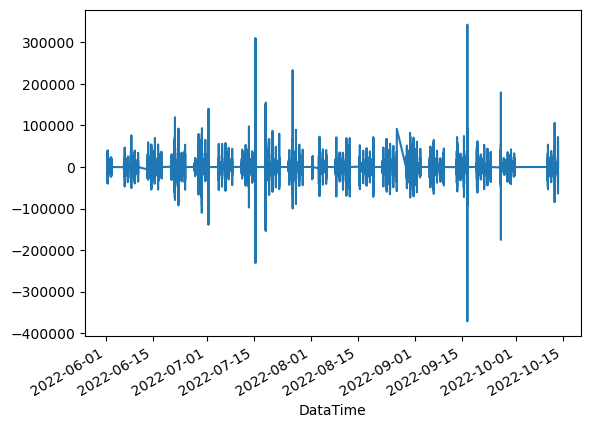

In [17]:
df_002521_signals['momentum'].plot() # results of 002521

<Axes: xlabel='DataTime'>

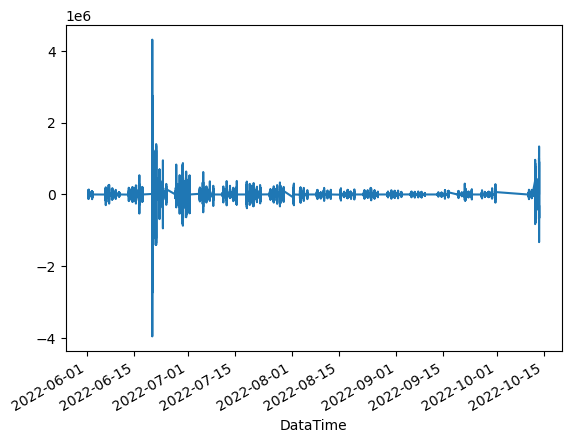

In [18]:
df_300132_signals['momentum'].plot() # results of 300132

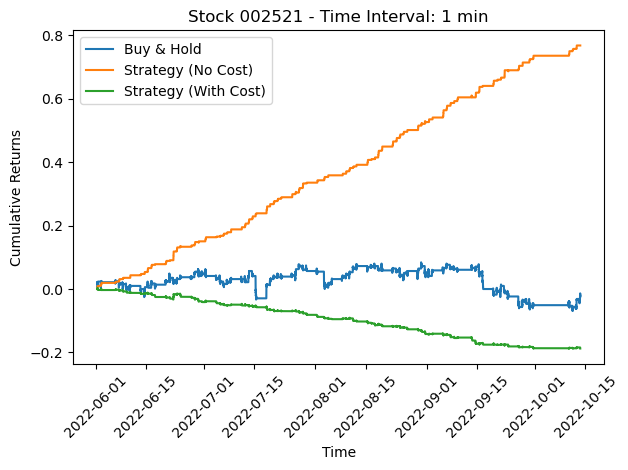

Final Buy & Hold Return:         -0.023503482
Final Strategy Return (No Cost): 0.7676251252155062
Final Strategy Return (Cost):    -0.18752510904343833


In [19]:
df_time = df_002521_signals.copy()
df_min = df_time.resample("1min").agg({
    "LastPrice": "last",     
    "Turnover": "sum",
    "momentum": "last",
    "returns": "last",
})

df_min.dropna(how="all", inplace=True)   # drop completely empty rows

# df_min["LastPrice"].fillna(method="ffill", inplace=True)
df_min["LastPrice"] = df_min["LastPrice"].ffill()

df = df_min.copy()

# ---------------------------------
# 1) Define thresholds for the momentum signal
# ---------------------------------
buy_threshold = -12000   # Example: Buy when momentum < -0.1%
sell_threshold = 10000   # Example: Sell/short when momentum > 0.1%

# Create a long-only signal: 0 or 1
df['signal'] = 0
df.loc[df['momentum'] < buy_threshold, 'signal'] = 1
# In a simple logic, exit if momentum is above sell_threshold
df.loc[df['momentum'] > sell_threshold, 'signal'] = 0
# The rest stays whatever it was, but we keep it simple: 
# if not < buy_threshold, it's 0 by default.

# Compute daily (or bar) returns from LastPrice
df['returns'] = df['LastPrice'].pct_change()

# Shift signal by 1 bar to avoid look-ahead bias
df['signal_shifted'] = df['signal'].shift(1)
df.dropna(subset=['signal_shifted', 'returns'], inplace=True)

# ---------------------------------
# 2) Compute Strategy Returns (No Costs)
# ---------------------------------
df['strategy_returns'] = df['signal_shifted'] * df['returns']

# ---------------------------------
# 3) Calculate Transaction Costs
# ---------------------------------
# Only two transitions matter:
#   - 0 -> 1  : net buy of 1 => cost = 2 bps
#   - 1 -> 0  : net sell of 1 => cost = 12 bps

def calc_long_only_cost(old_signal, new_signal, buy_bps=0.0002, sell_bps=0.0012):
    """
    Returns the cost (as fraction of capital) for a long-only strategy
    transitioning from old_signal to new_signal in {0,1}.
    """
    if (old_signal == 0 and new_signal == 1):
        # Opening a long (buy)
        return buy_bps
    elif (old_signal == 1 and new_signal == 0):
        # Closing a long (sell)
        return sell_bps
    else:
        # No change in position => no transaction cost
        return 0.0

df['old_signal'] = df['signal_shifted'].shift(1).fillna(0)

df['new_signal'] = df['signal_shifted']

df.dropna(subset=['old_signal', 'new_signal'], inplace=True)

df['cost'] = df.apply(lambda row: calc_long_only_cost(
    row['old_signal'],
    row['new_signal'],
    buy_bps=0.0002,   # 2 bps
    sell_bps=0.0012   # 12 bps
), axis=1)

# Subtract costs from the strategy returns
# We treat the cost as a fraction of total capital for simplicity.
df['strategy_returns_net'] = df['strategy_returns'] - df['cost']

# ---------------------------------
# 4) Cumulative Returns
# ---------------------------------
df['cumulative_strategy']     = (1 + df['strategy_returns']).cumprod() - 1
df['cumulative_strategy_net'] = (1 + df['strategy_returns_net']).cumprod() - 1
df['cumulative_market']       = (1 + df['returns']).cumprod() - 1

# ---------------------------------
# 5) Plot & Compare
# ---------------------------------
plt.figure()
plt.plot(df.index, df['cumulative_market'],       label='Buy & Hold')
plt.plot(df.index, df['cumulative_strategy'],     label='Strategy (No Cost)')
plt.plot(df.index, df['cumulative_strategy_net'], label='Strategy (With Cost)')
plt.title('Stock 002521 - Time Interval: 1 min')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

final_no_cost  = df['cumulative_strategy'].iloc[-1]
final_with_cost= df['cumulative_strategy_net'].iloc[-1]
final_market   = df['cumulative_market'].iloc[-1]

print("Final Buy & Hold Return:        ", final_market)
print("Final Strategy Return (No Cost):", final_no_cost)
print("Final Strategy Return (Cost):   ", final_with_cost)

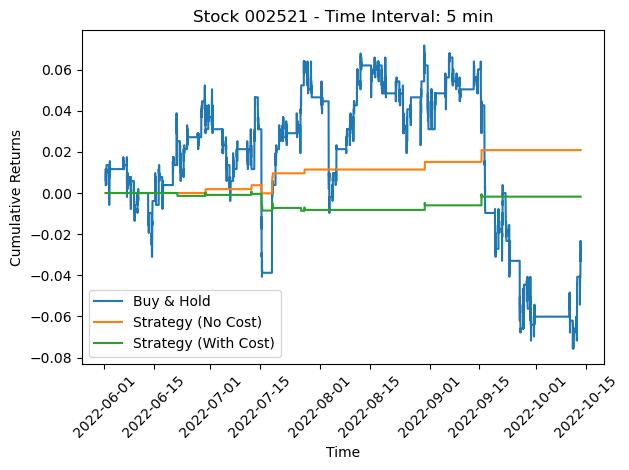

Final Buy & Hold Return:         -0.03295797
Final Strategy Return (No Cost): 0.020852482088925317
Final Strategy Return (Cost):    -0.0017681205969043434


In [20]:
df_time = df_002521_signals.copy()
df_min = df_time.resample("5min").agg({
    "LastPrice": "last",     
    "Turnover": "sum",
    "momentum": "last",
    "returns": "last",
})

df_min.dropna(how="all", inplace=True)   # drop completely empty rows

# df_min["LastPrice"].fillna(method="ffill", inplace=True)
df_min["LastPrice"] = df_min["LastPrice"].ffill()

df = df_min.copy()

# ---------------------------------
# 1) Define thresholds for the momentum signal
# ---------------------------------
buy_threshold = -32000   # Example: Buy when momentum < -0.1%
sell_threshold = 30000   # Example: Sell/short when momentum > 0.1%

# Create a long-only signal: 0 or 1
df['signal'] = 0
df.loc[df['momentum'] < buy_threshold, 'signal'] = 1
# In a simple logic, exit if momentum is above sell_threshold
df.loc[df['momentum'] > sell_threshold, 'signal'] = 0
# The rest stays whatever it was, but we keep it simple: 
# if not < buy_threshold, it's 0 by default.

# Compute daily (or bar) returns from LastPrice
df['returns'] = df['LastPrice'].pct_change()

# Shift signal by 1 bar to avoid look-ahead bias
df['signal_shifted'] = df['signal'].shift(1)
df.dropna(subset=['signal_shifted', 'returns'], inplace=True)

# ---------------------------------
# 2) Compute Strategy Returns (No Costs)
# ---------------------------------
df['strategy_returns'] = df['signal_shifted'] * df['returns']

# ---------------------------------
# 3) Calculate Transaction Costs
# ---------------------------------
# Only two transitions matter:
#   - 0 -> 1  : net buy of 1 => cost = 2 bps
#   - 1 -> 0  : net sell of 1 => cost = 12 bps

def calc_long_only_cost(old_signal, new_signal, buy_bps=0.0002, sell_bps=0.0012):
    """
    Returns the cost (as fraction of capital) for a long-only strategy
    transitioning from old_signal to new_signal in {0,1}.
    """
    if (old_signal == 0 and new_signal == 1):
        # Opening a long (buy)
        return buy_bps
    elif (old_signal == 1 and new_signal == 0):
        # Closing a long (sell)
        return sell_bps
    else:
        # No change in position => no transaction cost
        return 0.0

df['old_signal'] = df['signal_shifted'].shift(1).fillna(0)

df['new_signal'] = df['signal_shifted']

df.dropna(subset=['old_signal', 'new_signal'], inplace=True)

df['cost'] = df.apply(lambda row: calc_long_only_cost(
    row['old_signal'],
    row['new_signal'],
    buy_bps=0.0002,   # 2 bps
    sell_bps=0.0012   # 12 bps
), axis=1)

# Subtract costs from the strategy returns
# We treat the cost as a fraction of total capital for simplicity.
df['strategy_returns_net'] = df['strategy_returns'] - df['cost']

# ---------------------------------
# 4) Cumulative Returns
# ---------------------------------
df['cumulative_strategy']     = (1 + df['strategy_returns']).cumprod() - 1
df['cumulative_strategy_net'] = (1 + df['strategy_returns_net']).cumprod() - 1
df['cumulative_market']       = (1 + df['returns']).cumprod() - 1

# ---------------------------------
# 5) Plot & Compare
# ---------------------------------
plt.figure()
plt.plot(df.index, df['cumulative_market'],       label='Buy & Hold')
plt.plot(df.index, df['cumulative_strategy'],     label='Strategy (No Cost)')
plt.plot(df.index, df['cumulative_strategy_net'], label='Strategy (With Cost)')
plt.title('Stock 002521 - Time Interval: 5 min')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

final_no_cost  = df['cumulative_strategy'].iloc[-1]
final_with_cost= df['cumulative_strategy_net'].iloc[-1]
final_market   = df['cumulative_market'].iloc[-1]

print("Final Buy & Hold Return:        ", final_market)
print("Final Strategy Return (No Cost):", final_no_cost)
print("Final Strategy Return (Cost):   ", final_with_cost)

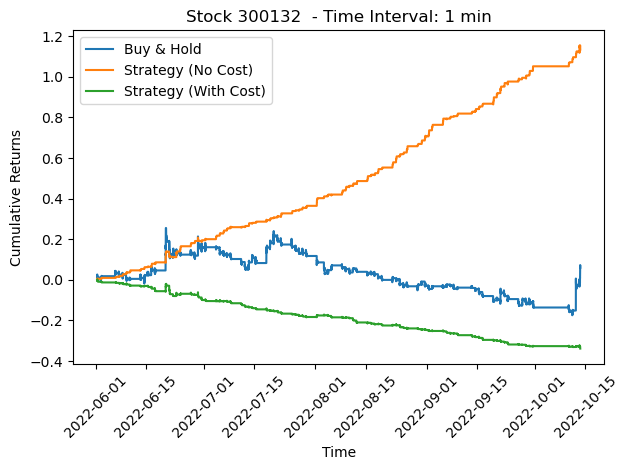

Final Buy & Hold Return:         0.059663773
Final Strategy Return (No Cost): 1.1340663565055924
Final Strategy Return (Cost):    -0.3382359546167426


In [21]:
df_time = df_300132_signals.copy()
df_min = df_time.resample("1min").agg({
    "LastPrice": "last",     
    "Turnover": "sum",
    "momentum": "last",
    "returns": "last",
})

df_min.dropna(how="all", inplace=True)   # drop completely empty rows

# df_min["LastPrice"].fillna(method="ffill", inplace=True)
df_min["LastPrice"] = df_min["LastPrice"].ffill()

df = df_min.copy()

# ---------------------------------
# 1) Define thresholds for the momentum signal
# ---------------------------------
buy_threshold = -5200   # Example: Buy when momentum < -0.1%
sell_threshold = 5000  # Example: Sell/short when momentum > 0.1%

# Create a long-only signal: 0 or 1
df['signal'] = 0
df.loc[df['momentum'] < buy_threshold, 'signal'] = 1
# In a simple logic, exit if momentum is above sell_threshold
df.loc[df['momentum'] > sell_threshold, 'signal'] = 0
# The rest stays whatever it was, but we keep it simple: 
# if not < buy_threshold, it's 0 by default.

# Compute daily (or bar) returns from LastPrice
df['returns'] = df['LastPrice'].pct_change()

# Shift signal by 1 bar to avoid look-ahead bias
df['signal_shifted'] = df['signal'].shift(1)
df.dropna(subset=['signal_shifted', 'returns'], inplace=True)

# ---------------------------------
# 2) Compute Strategy Returns (No Costs)
# ---------------------------------
df['strategy_returns'] = df['signal_shifted'] * df['returns']

# ---------------------------------
# 3) Calculate Transaction Costs
# ---------------------------------
# Only two transitions matter:
#   - 0 -> 1  : net buy of 1 => cost = 2 bps
#   - 1 -> 0  : net sell of 1 => cost = 12 bps

def calc_long_only_cost(old_signal, new_signal, buy_bps=0.0002, sell_bps=0.0012):
    """
    Returns the cost (as fraction of capital) for a long-only strategy
    transitioning from old_signal to new_signal in {0,1}.
    """
    if (old_signal == 0 and new_signal == 1):
        # Opening a long (buy)
        return buy_bps
    elif (old_signal == 1 and new_signal == 0):
        # Closing a long (sell)
        return sell_bps
    else:
        # No change in position => no transaction cost
        return 0.0

df['old_signal'] = df['signal_shifted'].shift(1).fillna(0)
df['new_signal'] = df['signal_shifted']

df.dropna(subset=['old_signal', 'new_signal'], inplace=True)

df['cost'] = df.apply(lambda row: calc_long_only_cost(
    row['old_signal'],
    row['new_signal'],
    buy_bps=0.0002,   # 2 bps
    sell_bps=0.0012   # 12 bps
), axis=1)

# Subtract costs from the strategy returns
# We treat the cost as a fraction of total capital for simplicity.
df['strategy_returns_net'] = df['strategy_returns'] - df['cost']

# ---------------------------------
# 4) Cumulative Returns
# ---------------------------------
df['cumulative_strategy']     = (1 + df['strategy_returns']).cumprod() - 1
df['cumulative_strategy_net'] = (1 + df['strategy_returns_net']).cumprod() - 1
df['cumulative_market']       = (1 + df['returns']).cumprod() - 1

# ---------------------------------
# 5) Plot & Compare
# ---------------------------------
plt.figure()
plt.plot(df.index, df['cumulative_market'],       label='Buy & Hold')
plt.plot(df.index, df['cumulative_strategy'],     label='Strategy (No Cost)')
plt.plot(df.index, df['cumulative_strategy_net'], label='Strategy (With Cost)')
plt.title('Stock 300132  - Time Interval: 1 min')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

final_no_cost  = df['cumulative_strategy'].iloc[-1]
final_with_cost= df['cumulative_strategy_net'].iloc[-1]
final_market   = df['cumulative_market'].iloc[-1]

print("Final Buy & Hold Return:        ", final_market)
print("Final Strategy Return (No Cost):", final_no_cost)
print("Final Strategy Return (Cost):   ", final_with_cost)

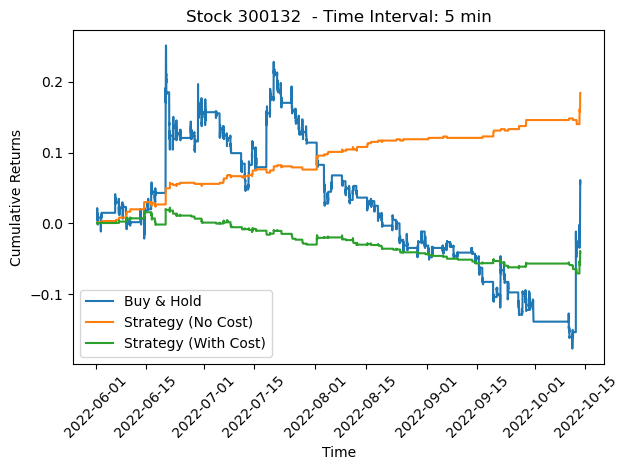

Final Buy & Hold Return:         0.056187868
Final Strategy Return (No Cost): 0.18426994227210902
Final Strategy Return (Cost):    -0.04146883868478335


In [22]:
df_time = df_300132_signals.copy()
df_min = df_time.resample("5min").agg({
    "LastPrice": "last",     
    "Turnover": "sum",
    "momentum": "last",
    "returns": "last",
})

df_min.dropna(how="all", inplace=True)   # drop completely empty rows

# df_min["LastPrice"].fillna(method="ffill", inplace=True)
df_min["LastPrice"] = df_min["LastPrice"].ffill()

df = df_min.copy()

# ---------------------------------
# 1) Define thresholds for the momentum signal
# ---------------------------------
buy_threshold = -22000   # Example: Buy when momentum < -0.1%
sell_threshold = 20000  # Example: Sell/short when momentum > 0.1%

# Create a long-only signal: 0 or 1
df['signal'] = 0
df.loc[df['momentum'] < buy_threshold, 'signal'] = 1
# In a simple logic, exit if momentum is above sell_threshold
df.loc[df['momentum'] > sell_threshold, 'signal'] = 0
# The rest stays whatever it was, but we keep it simple: 
# if not < buy_threshold, it's 0 by default.

# Compute daily (or bar) returns from LastPrice
df['returns'] = df['LastPrice'].pct_change()

# Shift signal by 1 bar to avoid look-ahead bias
df['signal_shifted'] = df['signal'].shift(1)
df.dropna(subset=['signal_shifted', 'returns'], inplace=True)

# ---------------------------------
# 2) Compute Strategy Returns (No Costs)
# ---------------------------------
df['strategy_returns'] = df['signal_shifted'] * df['returns']

# ---------------------------------
# 3) Calculate Transaction Costs
# ---------------------------------
# Only two transitions matter:
#   - 0 -> 1  : net buy of 1 => cost = 2 bps
#   - 1 -> 0  : net sell of 1 => cost = 12 bps

def calc_long_only_cost(old_signal, new_signal, buy_bps=0.0002, sell_bps=0.0012):
    """
    Returns the cost (as fraction of capital) for a long-only strategy
    transitioning from old_signal to new_signal in {0,1}.
    """
    if (old_signal == 0 and new_signal == 1):
        # Opening a long (buy)
        return buy_bps
    elif (old_signal == 1 and new_signal == 0):
        # Closing a long (sell)
        return sell_bps
    else:
        # No change in position => no transaction cost
        return 0.0

df['old_signal'] = df['signal_shifted'].shift(1).fillna(0)

df['new_signal'] = df['signal_shifted']

df.dropna(subset=['old_signal', 'new_signal'], inplace=True)

df['cost'] = df.apply(lambda row: calc_long_only_cost(
    row['old_signal'],
    row['new_signal'],
    buy_bps=0.0002,   # 2 bps
    sell_bps=0.0012   # 12 bps
), axis=1)

# Subtract costs from the strategy returns
# We treat the cost as a fraction of total capital for simplicity.
df['strategy_returns_net'] = df['strategy_returns'] - df['cost']

# ---------------------------------
# 4) Cumulative Returns
# ---------------------------------
df['cumulative_strategy']     = (1 + df['strategy_returns']).cumprod() - 1
df['cumulative_strategy_net'] = (1 + df['strategy_returns_net']).cumprod() - 1
df['cumulative_market']       = (1 + df['returns']).cumprod() - 1

# ---------------------------------
# 5) Plot & Compare
# ---------------------------------
plt.figure()
plt.plot(df.index, df['cumulative_market'],       label='Buy & Hold')
plt.plot(df.index, df['cumulative_strategy'],     label='Strategy (No Cost)')
plt.plot(df.index, df['cumulative_strategy_net'], label='Strategy (With Cost)')
plt.title('Stock 300132  - Time Interval: 5 min')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

final_no_cost  = df['cumulative_strategy'].iloc[-1]
final_with_cost= df['cumulative_strategy_net'].iloc[-1]
final_market   = df['cumulative_market'].iloc[-1]

print("Final Buy & Hold Return:        ", final_market)
print("Final Strategy Return (No Cost):", final_no_cost)
print("Final Strategy Return (Cost):   ", final_with_cost)

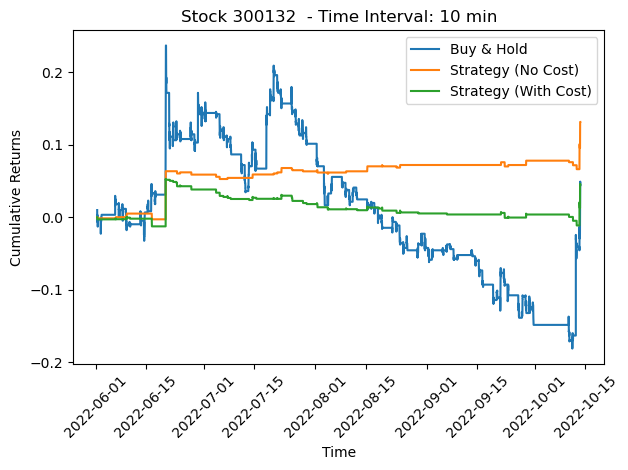

Final Buy & Hold Return:         0.044118285
Final Strategy Return (No Cost): 0.1313992887446087
Final Strategy Return (Cost):    0.04460310567682746


In [23]:
df_time = df_300132_signals.copy()
df_min = df_time.resample("10min").agg({
    "LastPrice": "last",     
    "Turnover": "sum",
    "momentum": "last",
    "returns": "last",
})

df_min.dropna(how="all", inplace=True)   # drop completely empty rows

# df_min["LastPrice"].fillna(method="ffill", inplace=True)
df_min["LastPrice"] = df_min["LastPrice"].ffill()

df = df_min.copy()

# ---------------------------------
# 1) Define thresholds for the momentum signal
# ---------------------------------
buy_threshold = -32000   
sell_threshold = 30000 

# Create a long-only signal: 0 or 1
df['signal'] = 0
df.loc[df['momentum'] < buy_threshold, 'signal'] = 1
# In a simple logic, exit if momentum is above sell_threshold
df.loc[df['momentum'] > sell_threshold, 'signal'] = 0
# The rest stays whatever it was, but we keep it simple: 
# if not < buy_threshold, it's 0 by default.

# Compute daily (or bar) returns from LastPrice
df['returns'] = df['LastPrice'].pct_change()

# Shift signal by 1 bar to avoid look-ahead bias
df['signal_shifted'] = df['signal'].shift(1)
df.dropna(subset=['signal_shifted', 'returns'], inplace=True)

# ---------------------------------
# 2) Compute Strategy Returns (No Costs)
# ---------------------------------
df['strategy_returns'] = df['signal_shifted'] * df['returns']

# ---------------------------------
# 3) Calculate Transaction Costs
# ---------------------------------
# Only two transitions matter:
#   - 0 -> 1  : net buy of 1 => cost = 2 bps
#   - 1 -> 0  : net sell of 1 => cost = 12 bps

def calc_long_only_cost(old_signal, new_signal, buy_bps=0.0002, sell_bps=0.0012):
    """
    Returns the cost (as fraction of capital) for a long-only strategy
    transitioning from old_signal to new_signal in {0,1}.
    """
    if (old_signal == 0 and new_signal == 1):
        # Opening a long (buy)
        return buy_bps
    elif (old_signal == 1 and new_signal == 0):
        # Closing a long (sell)
        return sell_bps
    else:
        # No change in position => no transaction cost
        return 0.0

df['old_signal'] = df['signal_shifted'].shift(1).fillna(0)

df['new_signal'] = df['signal_shifted']

df.dropna(subset=['old_signal', 'new_signal'], inplace=True)

df['cost'] = df.apply(lambda row: calc_long_only_cost(
    row['old_signal'],
    row['new_signal'],
    buy_bps=0.0002,   # 2 bps
    sell_bps=0.0012   # 12 bps
), axis=1)

# Subtract costs from the strategy returns
# We treat the cost as a fraction of total capital for simplicity.
df['strategy_returns_net'] = df['strategy_returns'] - df['cost']

# ---------------------------------
# 4) Cumulative Returns
# ---------------------------------
df['cumulative_strategy']     = (1 + df['strategy_returns']).cumprod() - 1
df['cumulative_strategy_net'] = (1 + df['strategy_returns_net']).cumprod() - 1
df['cumulative_market']       = (1 + df['returns']).cumprod() - 1

# ---------------------------------
# 5) Plot & Compare
# ---------------------------------
plt.figure()
plt.plot(df.index, df['cumulative_market'],       label='Buy & Hold')
plt.plot(df.index, df['cumulative_strategy'],     label='Strategy (No Cost)')
plt.plot(df.index, df['cumulative_strategy_net'], label='Strategy (With Cost)')
plt.title('Stock 300132  - Time Interval: 10 min')
plt.xlabel('Time')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

final_no_cost  = df['cumulative_strategy'].iloc[-1]
final_with_cost= df['cumulative_strategy_net'].iloc[-1]
final_market   = df['cumulative_market'].iloc[-1]

print("Final Buy & Hold Return:        ", final_market)
print("Final Strategy Return (No Cost):", final_no_cost)
print("Final Strategy Return (Cost):   ", final_with_cost)

## 4. Further strategy development - Predicate last 5 mins price using Tree-based LightGBM Model
- intraday trading volume increases significantly toward the market close, indicating more trading opportunities at the end of the day.
- 1‑minute frequency data and the 104 established features are used to forecast the stock price in the last 5 minutes of the trading session.

### 4.1 Stock 002521

In [24]:
df_p = df_002521_signals.resample("1min").agg({
    "LastPrice": "last",          # use the last observed price
    "Turnover": "sum",            # sum turnover within the minute
    "Volume": "last",             # use the last recorded volume
    "total_bid_volume": "last",    # sum total bid volume over the minute
    "total_ask_volume": "last",    # sum total ask volume over the minute
    "total_volume": "last",        # sum total volume over the minute
    "imbalance": "last",          # take the last imbalance value
    "delta_imbalance": "last",    # take the last delta imbalance value
    "rolling_delta_imb": "last",  # take the last rolling delta imbalance value
    "returns": "last",            # use the last return
    "daily_vol": "mean",          # average daily volatility (adjust if needed)
    "weekly_vol": "mean",         # average weekly volatility
    "monthly_vol": "mean",        # average monthly volatility
    "hourly_vol": "mean",         # average hourly volatility
    "min_vol": "mean",            # average minute-level volatility
    "sec_vol": "mean",            # average second-level volatility
    "tenth_sec_vol": "mean",      # average tenth-second volatility
    "momentum": "last",           # use the last momentum value
    "midprice": "mean",           # average midprice
    "spread": "mean",
    "AveragePrice": "last",            # average spread
    'AskPrice1': "last", 'AskPrice10': "last", 'AskPrice2': "last", 'AskPrice3': "last", 'AskPrice4': "last",
    'AskPrice5': "last", 'AskPrice6': "last", 'AskPrice7': "last", 'AskPrice8': "last", 'AskPrice9': "last",
    'AskVolume1': "last", 'AskVolume10': "last", 'AskVolume2': "last", 'AskVolume3': "last", 'AskVolume4': "last",
    'AskVolume5': "last", 'AskVolume6': "last", 'AskVolume7': "last", 'AskVolume8': "last", 'AskVolume9': "last",
    'AveragePrice': "last", 'BidPrice1': "last", 'BidPrice10': "last", 'BidPrice2': "last", 'BidPrice3': "last",
    'BidPrice4': "last", 'BidPrice5': "last", 'BidPrice6': "last", 'BidPrice7': "last", 'BidPrice8': "last",
    'BidPrice9': "last", 'BidVolume1': "last", 'BidVolume10': "last", 'BidVolume2': "last", 'BidVolume3': "last",
    'BidVolume4': "last",
    "liquidity_imbalance": "last",
    "size_imbalance": "last",
    "spread_intensity": "last",
    "market_urgency": "last",
    "order_book_imbalance": "last",
    "weighted_bid_price": "last",
    "weighted_ask_price": "last",
    "bid_price_gap": "last",
    "ask_price_gap": "last",
    "bid_price_diff_1_2": "last",
    "ask_price_diff_1_2": "last",
    "bid_price_diff_2_3": "last",
    "ask_price_diff_2_3": "last",
    "bid_price_diff_3_4": "last",
    "ask_price_diff_3_4": "last",
    "bid_price_diff_4_5": "last",
    "ask_price_diff_4_5": "last",
    "bid_price_diff_5_6": "last",
    "ask_price_diff_5_6": "last",
    "bid_price_diff_6_7": "last",
    "ask_price_diff_6_7": "last",
    "bid_price_diff_7_8": "last",
    "ask_price_diff_7_8": "last",
    "bid_price_diff_8_9": "last",
    "ask_price_diff_8_9": "last",
    "bid_price_diff_9_10": "last",
    "ask_price_diff_9_10": "last",
    "avg_bid_price": "last",
    "avg_ask_price": "last",
    "median_bid_price": "last",
    "median_ask_price": "last",
    "std_bid_price": "last",
    "std_ask_price": "last",
    "best_volume_ratio": "last",
    "volume_ratio": "last",
    "top3_bid_volume": "last",
    "top3_ask_volume": "last",
    "top3_volume_ratio": "last",
    "spread_level_1": "last",
    "spread_level_2": "last",
    "spread_level_3": "last",
    "spread_level_4": "last",
    "spread_level_5": "last",
    "spread_level_6": "last",
    "spread_level_7": "last",
    "spread_level_8": "last",
    "spread_level_9": "last",
    "spread_level_10": "last"

})
df_p.dropna(how="any", inplace=True)  # drop completely empty rows

# df_p["LastPrice"].fillna(method="ffill", inplace=True)
df_p["LastPrice"] = df_p["LastPrice"].ffill()

In [25]:
# Deviding training and testng data
df_train = df_p.groupby(df_p.index.date, group_keys=False).apply(lambda x: x.iloc[:-5])
test = df_p.groupby(df_p.index.date, group_keys=False).apply(lambda x: x.tail(5))

In [26]:
from lightgbm import early_stopping

features = df_train.columns.drop('LastPrice')
X = df_train[features]
y = df_train['LastPrice']
tscv = TimeSeriesSplit(n_splits=10)
mae_scores = []
fold = 1

for train_index, val_index in tscv.split(X):
    # Split the data for this fold
    X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Prepare LightGBM datasets
    lgb_train = lgb.Dataset(X_tr, label=y_tr)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
    
    # Set up parameters for regression; adjust these as needed for your task
    params = {
        "objective": "mae",
        "n_estimators": 2000,
        "num_leaves": 256,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
        "learning_rate": 0.01,
        'max_depth': 11,
        "n_jobs": 4,
        "verbosity": -1,
        "importance_type": "gain",
        "reg_alpha": 0.2,
        "reg_lambda": 3.25
    }
    
    # Train the model with early stopping
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[early_stopping(stopping_rounds=50)],
    )

    # Predict on the validation set
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    mae = mean_absolute_error(y_val, y_pred)
    mae_scores.append(mae)
    
    print(f"Fold {fold} MAE: {mae:.4f}")
    fold += 1

# Compute the average RMSE across all folds
print("Average MAE:", np.mean(mae_scores))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1325]	training's l1: 0.00163414	valid_1's l1: 0.0157269
Fold 1 MAE: 0.0157
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1441]	training's l1: 0.00167087	valid_1's l1: 0.0180373
Fold 2 MAE: 0.0180
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[798]	training's l1: 0.00222211	valid_1's l1: 0.00652504
Fold 3 MAE: 0.0065
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1750]	training's l1: 0.00163006	valid_1's l1: 0.0128967
Fold 4 MAE: 0.0129
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[846]	training's l1: 0.00231731	valid_1's l1: 0.00454301
Fold 5 MAE: 0.0045
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1584]	training's l1: 0.00181228	valid_1's l

Above results show Average MAE = 0.0099, demonstrating the accuracy of the predication

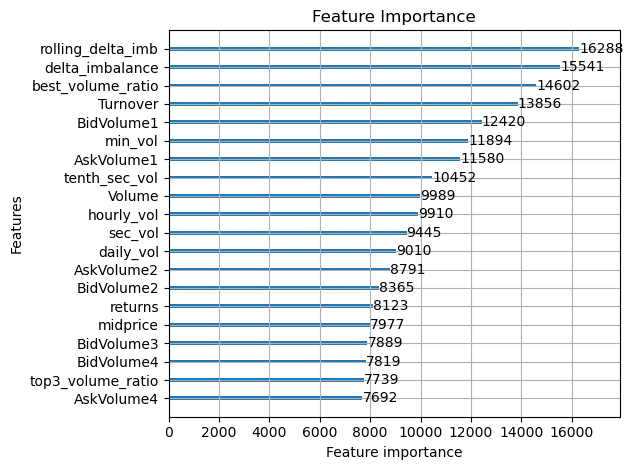

In [27]:
ax = lgb.plot_importance(model, max_num_features=20, importance_type='split')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

In [28]:
features_test = test.columns.drop('LastPrice')
X_test = test[features_test]
y_test = test['LastPrice']

# Use trained model to predict the target for the test set.
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Compute performance metrics
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)

Test RMSE: 0.006782923826558435
Test MAE: 0.004846769610882228


### 4.2 Stock 300132

In [29]:
df_p = df_300132_signals.resample("1min").agg({
    "LastPrice": "last",          # use the last observed price
    "Turnover": "sum",            # sum turnover within the minute
    "Volume": "last",             # use the last recorded volume
    "total_bid_volume": "last",    # sum total bid volume over the minute
    "total_ask_volume": "last",    # sum total ask volume over the minute
    "total_volume": "last",        # sum total volume over the minute
    "imbalance": "last",          # take the last imbalance value
    "delta_imbalance": "last",    # take the last delta imbalance value
    "rolling_delta_imb": "last",  # take the last rolling delta imbalance value
    "returns": "last",            # use the last return
    "daily_vol": "mean",          # average daily volatility (adjust if needed)
    "weekly_vol": "mean",         # average weekly volatility
    "monthly_vol": "mean",        # average monthly volatility
    "hourly_vol": "mean",         # average hourly volatility
    "min_vol": "mean",            # average minute-level volatility
    # "sec_vol": "mean",            # average second-level volatility
    # "tenth_sec_vol": "mean",      # average tenth-second volatility
    "momentum": "last",           # use the last momentum value
    "midprice": "mean",           # average midprice
    "spread": "mean",
    "AveragePrice": "last",            # average spread
    'AskPrice1': "last", 'AskPrice10': "last", 'AskPrice2': "last", 'AskPrice3': "last", 'AskPrice4': "last",
    'AskPrice5': "last", 'AskPrice6': "last", 'AskPrice7': "last", 'AskPrice8': "last", 'AskPrice9': "last",
    'AskVolume1': "last", 'AskVolume10': "last", 'AskVolume2': "last", 'AskVolume3': "last", 'AskVolume4': "last",
    'AskVolume5': "last", 'AskVolume6': "last", 'AskVolume7': "last", 'AskVolume8': "last", 'AskVolume9': "last",
    'AveragePrice': "last", 'BidPrice1': "last", 'BidPrice10': "last", 'BidPrice2': "last", 'BidPrice3': "last",
    'BidPrice4': "last", 'BidPrice5': "last", 'BidPrice6': "last", 'BidPrice7': "last", 'BidPrice8': "last",
    'BidPrice9': "last", 'BidVolume1': "last", 'BidVolume10': "last", 'BidVolume2': "last", 'BidVolume3': "last",
    'BidVolume4': "last",
    "liquidity_imbalance": "last",
    "size_imbalance": "last",
    "spread_intensity": "last",
    "market_urgency": "last",
    "order_book_imbalance": "last",
    "weighted_bid_price": "last",
    "weighted_ask_price": "last",
    "bid_price_gap": "last",
    "ask_price_gap": "last",
    "bid_price_diff_1_2": "last",
    "ask_price_diff_1_2": "last",
    "bid_price_diff_2_3": "last",
    "ask_price_diff_2_3": "last",
    "bid_price_diff_3_4": "last",
    "ask_price_diff_3_4": "last",
    "bid_price_diff_4_5": "last",
    "ask_price_diff_4_5": "last",
    "bid_price_diff_5_6": "last",
    "ask_price_diff_5_6": "last",
    "bid_price_diff_6_7": "last",
    "ask_price_diff_6_7": "last",
    "bid_price_diff_7_8": "last",
    "ask_price_diff_7_8": "last",
    "bid_price_diff_8_9": "last",
    "ask_price_diff_8_9": "last",
    "bid_price_diff_9_10": "last",
    "ask_price_diff_9_10": "last",
    "avg_bid_price": "last",
    "avg_ask_price": "last",
    "median_bid_price": "last",
    "median_ask_price": "last",
    "std_bid_price": "last",
    "std_ask_price": "last",
    "best_volume_ratio": "last",
    "volume_ratio": "last",
    "top3_bid_volume": "last",
    "top3_ask_volume": "last",
    "top3_volume_ratio": "last",
    "spread_level_1": "last",
    "spread_level_2": "last",
    "spread_level_3": "last",
    "spread_level_4": "last",
    "spread_level_5": "last",
    "spread_level_6": "last",
    "spread_level_7": "last",
    "spread_level_8": "last",
    "spread_level_9": "last",
    "spread_level_10": "last"

})
df_p.dropna(how="any", inplace=True)  # drop completely empty rows

df_p["LastPrice"] = df_p["LastPrice"].ffill()

df_train = df_p.groupby(df_p.index.date, group_keys=False).apply(lambda x: x.iloc[:-5])
test = df_p.groupby(df_p.index.date, group_keys=False).apply(lambda x: x.tail(5))

features = df_train.columns.drop('LastPrice')
X = df_train[features]
y = df_train['LastPrice']
tscv = TimeSeriesSplit(n_splits=10)
mae_scores = []
fold = 1

for train_index, val_index in tscv.split(X):
    # Split the data for this fold
    X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Prepare LightGBM datasets
    lgb_train = lgb.Dataset(X_tr, label=y_tr)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
    
    # Set up parameters for regression; adjust these as needed for your task
    params = {
        "objective": "mae",
        "n_estimators": 3000,
        "num_leaves": 256,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
        "learning_rate": 0.01,
        'max_depth': 11,
        "n_jobs": 4,
        "verbosity": -1,
        "importance_type": "gain",
        "reg_alpha": 0.2,
        "reg_lambda": 3.25
    }
    
    # Train the model with early stopping
    model = lgb.train(
        
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[early_stopping(stopping_rounds=50)],
    )
    
    # Predict on the validation set
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    mae = mean_absolute_error(y_val, y_pred)
    mae_scores.append(mae)
    
    print(f"Fold {fold} MAE: {mae:.4f}")
    fold += 1

# Compute the average RMSE across all folds
print("Average MAE:", np.mean(mae_scores))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1880]	training's l1: 0.0013793	valid_1's l1: 0.339261
Fold 1 MAE: 0.3393
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[655]	training's l1: 0.00366635	valid_1's l1: 0.00658863
Fold 2 MAE: 0.0066
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[395]	training's l1: 0.0171775	valid_1's l1: 0.00756376
Fold 3 MAE: 0.0076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[891]	training's l1: 0.00266093	valid_1's l1: 0.00519605
Fold 4 MAE: 0.0052
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[452]	training's l1: 0.00763501	valid_1's l1: 0.00418739
Fold 5 MAE: 0.0042
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[876]	training's l1: 0.0027937	valid_1's l1: 0.

In [30]:
from lightgbm import early_stopping

features = df_train.columns.drop('LastPrice')
X = df_train[features]
y = df_train['LastPrice']
tscv = TimeSeriesSplit(n_splits=10)
mae_scores = []
fold = 1

for train_index, val_index in tscv.split(X):
    # Split the data for this fold
    X_tr, X_val = X.iloc[train_index], X.iloc[val_index]
    y_tr, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Prepare LightGBM datasets
    lgb_train = lgb.Dataset(X_tr, label=y_tr)
    lgb_val = lgb.Dataset(X_val, label=y_val, reference=lgb_train)
    
    # Set up parameters for regression; adjust these as needed for your task
    params = {
        "objective": "mae",
        "n_estimators": 2000,
        "num_leaves": 256,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
        "learning_rate": 0.01,
        'max_depth': 11,
        "n_jobs": 4,
        "verbosity": -1,
        "importance_type": "gain",
        "reg_alpha": 0.2,
        "reg_lambda": 3.25
    }
    
    # Train the model with early stopping
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=[lgb_train, lgb_val],
        callbacks=[early_stopping(stopping_rounds=50)],
    )

    # Predict on the validation set
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    mae = mean_absolute_error(y_val, y_pred)
    mae_scores.append(mae)
    
    print(f"Fold {fold} MAE: {mae:.4f}")
    fold += 1

# Compute the average RMSE across all folds
print("Average MAE:", np.mean(mae_scores))

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1880]	training's l1: 0.0013793	valid_1's l1: 0.339261
Fold 1 MAE: 0.3393
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[655]	training's l1: 0.00366635	valid_1's l1: 0.00658863
Fold 2 MAE: 0.0066
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[395]	training's l1: 0.0171775	valid_1's l1: 0.00756376
Fold 3 MAE: 0.0076
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[891]	training's l1: 0.00266093	valid_1's l1: 0.00519605
Fold 4 MAE: 0.0052
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[452]	training's l1: 0.00763501	valid_1's l1: 0.00418739
Fold 5 MAE: 0.0042
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[876]	training's l1: 0.0027937	valid_1's l1: 0.

In [31]:
features_test = test.columns.drop('LastPrice')
X_test = test[features_test]
y_test = test['LastPrice']

# Use your trained model to predict the target for the test set.
# (Assuming that your trained model is stored in the variable 'model' and was trained with early stopping.)
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration)

# Compute performance metrics
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print("Test RMSE:", rmse_test)
print("Test MAE:", mae_test)

Test RMSE: 0.030504836504529263
Test MAE: 0.009304176099293621


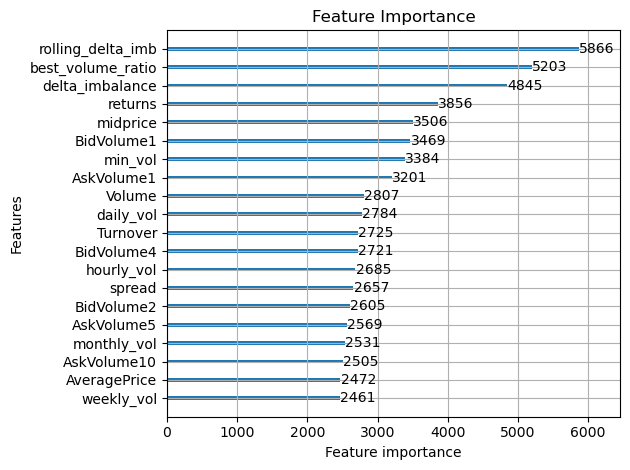

In [32]:
ax = lgb.plot_importance(model, max_num_features=20, importance_type='split')
plt.title("Feature Importance")
plt.tight_layout()
plt.show()